   # Spam classifier

In [67]:
#The used libs
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.tokenize import word_tokenize
import string
import spacy
spacy_nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



## Exploring our dataset

In [3]:
data = pd.read_table("smsspamcollection/SMSSpamCollection",sep='\t',names=['label', 'message']) 
# Output printing out first 5 rows
data.head(5)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


No.of Ham messages  4825
No.of Spam messages  747


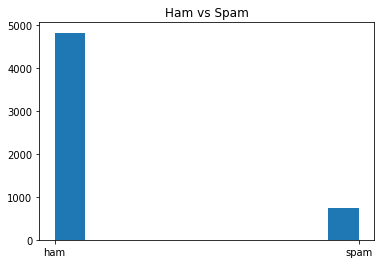

In [4]:
#Exploring how balancing the dataset is
print("No.of Ham messages ",data[data["label"]=="ham"].count()[0])
print("No.of Spam messages ",data[data["label"]=="spam"].count()[0])
fig, ax = plt.subplots(1, 1)
ax.hist(data["label"])
ax.set_title("Ham vs Spam")
plt.show()

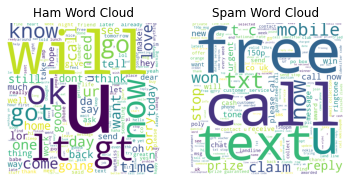

In [27]:
def t(label,col):
    comment_words = ''
    stopwords = set(STOPWORDS)
    # iterate through the ham sms_message 
    for m in data[data["label"]==str(label)][str(col)]:
            # split the message
            tokens = m.split()
            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()

            comment_words += " ".join(tokens)+" "
    return comment_words

Ham_wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 10).generate(t("ham","message"))
Spam_wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 10).generate(t("spam","message"))

# plot the WordCloud image 
figure,x = plt.subplots(1,2)
#plt.figure(figsize = (8, 8), facecolor = None)
x[0].imshow(Ham_wordcloud)
x[0].axis('off')
x[0].set_title("Ham Word Cloud")
x[1].imshow(Spam_wordcloud)
x[1].axis('off')
x[1].set_title("Spam Word Cloud")
#plt.tight_layout(pad = 0)

plt.show()

As you can see in the Ham word cloud some of the most famous words are [ will, u ] which aren't so helpful as they give us no good information regarding the meaning of the messages, So, In the next section, I clean the data and delete stop words from the messages.

## Data Preprocessing

1- Lower case Car --> car<br>
2- Retain alphabetic words only 1hi --> removed<br>
3- Remove all stop words<br>
4- Fixing text and txt problem<br>
5- Implement Lemmatization: Lemmatization is the grouping together of different forms of the same word. 

In [40]:
def clean(data): 
    messages = data
    #tokenize texts
    #tokens: list of lists of strings
    tokens = [word_tokenize(message) for message in messages]
    #print(tokens[0])
    lower_tokens = []
    for token in tokens:
        lower_tokens.append([t.lower() for t in token])
    # Retain alphabetic words: alpha_only
    alpha_only=[]
    for lower_token in lower_tokens:
        alpha_only .append( [t for t in lower_token if t.isalpha()])

    # Remove all stop words: no_stops
    stops=list(STOPWORDS)
    #Remove all the punctuations
    stops+=list(string.punctuation)
    #more words that doesn't matter to the clustring process
    stops+=['also','tls','one','two','three','four','u','la','e','n','five','six','seven','eight','nine','ten','first','second','third','fourth','will','ur','it','gt']
    no_stops=[]
    for m in alpha_only:
        no_stops.append( [t for t in m if t not in stops])
    #fixing text and txt problem
    #re-assmaple the messages 
    ss= [(" ".join(e for e in s)).replace("txt", "text") for s in no_stops]
    #print(ss)
    docs=[spacy_nlp(s) for s in ss]
    #print(docs)
    # Instantiate the WordNetLemmatizer
    
    #Lemmatization is the grouping together of different forms of 
    #the same word. In search queries, lemmatization allows end users 
    #to query any version of a base word and get relevant results
    lemmatized=[]
    for doc in docs:
        lemmatized_sentence = " ".join([token.lemma_ for token in doc])
        lemmatized.append(lemmatized_sentence)
    return lemmatized

In [111]:
example=clean(["I will be going to college",
               "You better be finshed with that task"])
example

['go college', 'well finshe task']

In [41]:
data['clean_message'] = clean(data['message'])
data.head()

,label,message,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live around though


#### Word cloud after cleaning the messages

Now looking at the ham word cloud again, we can see better results.<br>

The only problem is that the most famous words in the spam word cloud now contain words like: "text" and "txt" which are considered 2 different words while they're clearly the same word, I still don't know the ideal method to deal with such a problem so for now, I'm going to hard-code it.

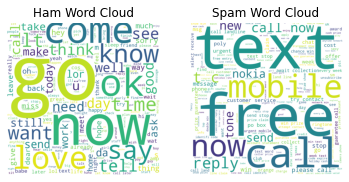

In [42]:

Ham_wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 10).generate(t("ham","clean_message"))
Spam_wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 10).generate(t("spam","clean_message"))

# plot the WordCloud image 
figure,x = plt.subplots(1,2)
#plt.figure(figsize = (8, 8), facecolor = None)
x[0].imshow(Ham_wordcloud)
x[0].axis('off')
x[0].set_title("Ham Word Cloud")
x[1].imshow(Spam_wordcloud)
x[1].axis('off')
x[1].set_title("Spam Word Cloud")
#plt.tight_layout(pad = 0)

plt.show()

### Label Encoding 

In [45]:
le = LabelEncoder()
le.fit(data['label'])
data['label_encoded'] = le.transform(data['label'])
data.head()

,label,message,clean_message,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts may...,1
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live around though,0


### Split the data into training and testing

Train on 80% of the data and test on the other 20% 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data['clean_message'], 
                                                    data['label_encoded'],
                                                    test_size=0.2,
                                                    random_state=1)

print('Number of rows in the total set: {}'.format(data.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 4457
Number of rows in the test set: 1115


#### Embedding the messages

We are going to use TF-IDF vectorization to represent the messages.<br>
We start by applying bag of words.<br>

**For some reason: a lot of the algorithims that I tried dosnt reaspond well to the usage of TF-IDF vectorization and gives better when using the counterVectorizer alone**

In [47]:
counter_vect = CountVectorizer()
counter_vect.fit(X_train)
# document-term matrix from train and test sets
x_tr_dtm = counter_vect.transform(X_train)
x_test_dtm = counter_vect.transform(X_test)

In [48]:
#applying tf-idf
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_tr_dtm)
x_tr_tfidf = tfidf_transformer.transform(x_tr_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

## Exploring different Models And Choosing the best one

In [74]:
def evaluat(y_pred,y_test):
    print('Recall score: ', format(recall_score(y_test,y_pred)))
    print('Accuracy score: ', format(accuracy_score(y_test,y_pred)))
    print('F1 score: ', format(f1_score(y_test,y_pred)))
    print('Precision score: ', format(precision_score(y_test,y_pred)))
    c=confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=c, figsize=(6, 6), cmap=plt.cm.Greens)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Ham:0   Spam:1', fontsize=18)
    plt.show()

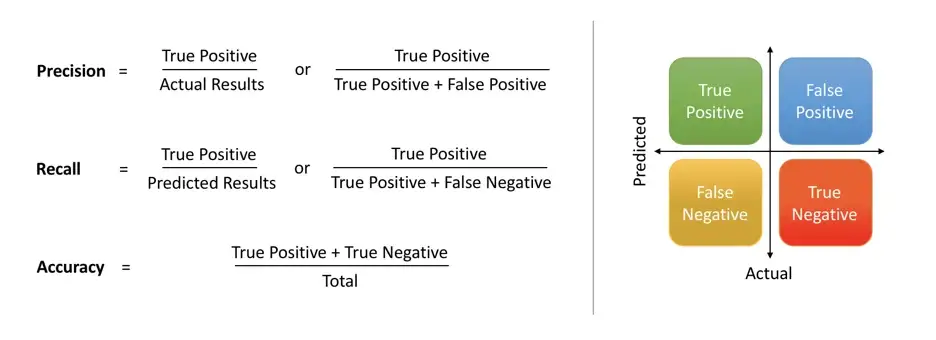



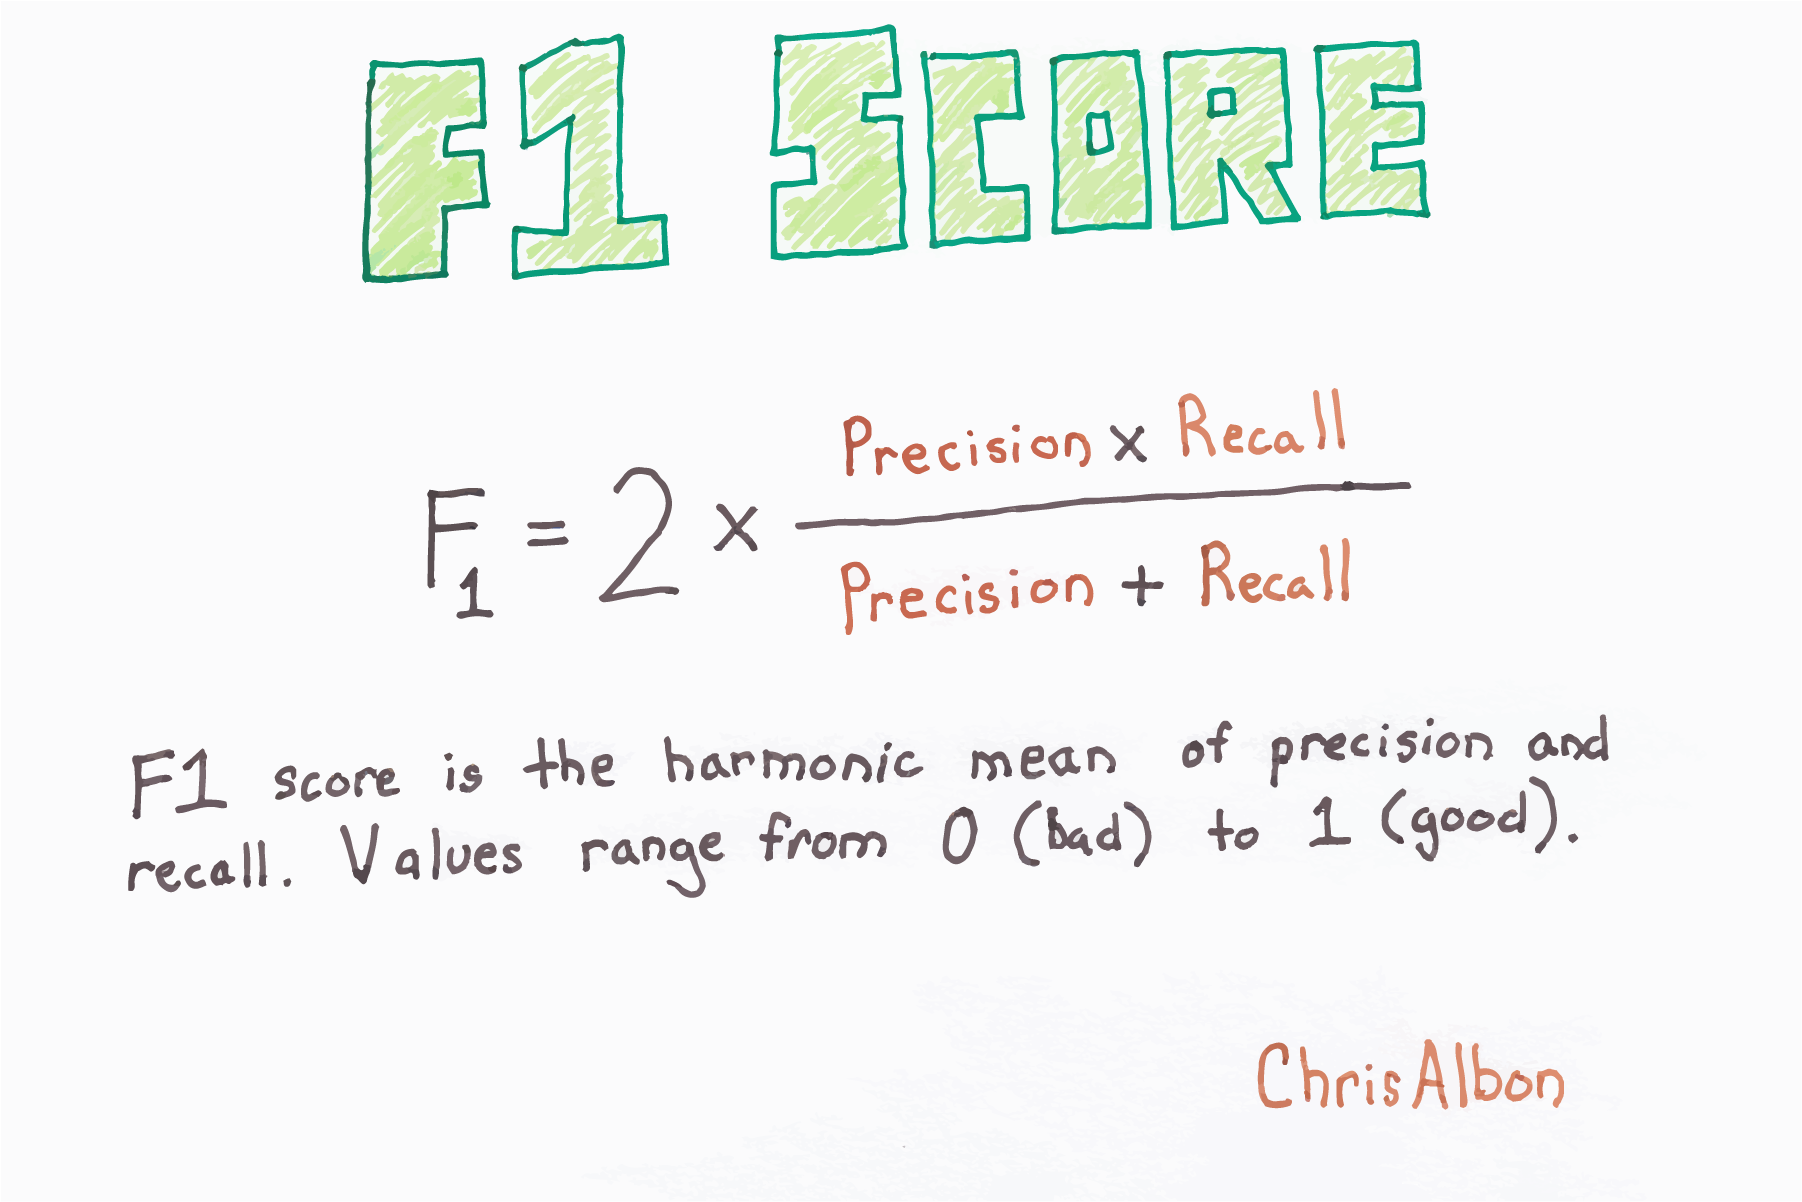

### Naive Bayes

Gives good results with CountVectorizer and worse results with TF-IDF<br>
Also very fast trainig

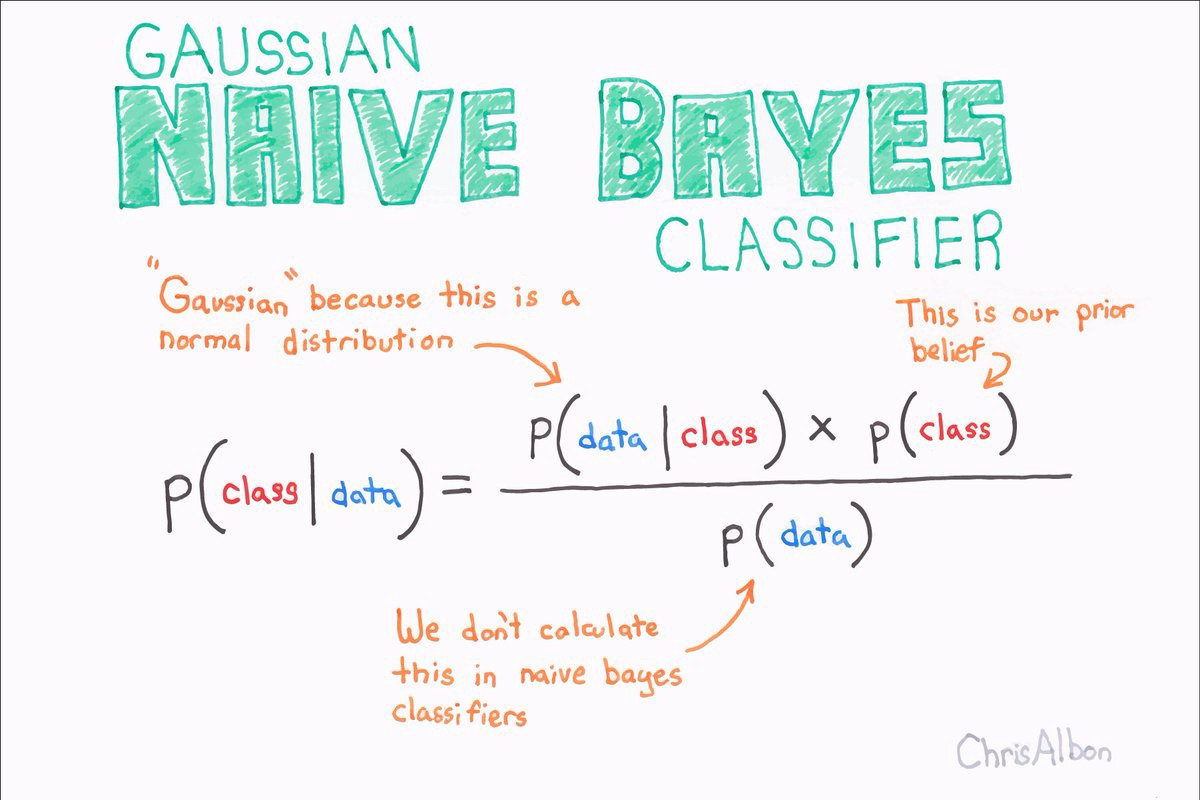

In [77]:
naive_bayes = MultinomialNB()
naive_bayes.fit(x_tr_dtm,y_train)

MultinomialNB()

In [78]:
nv_pred = naive_bayes.predict(x_test_dtm)

Recall score:  0.9523809523809523
Accuracy score:  0.9856502242152466
F1 score:  0.9459459459459459
Precision score:  0.9395973154362416


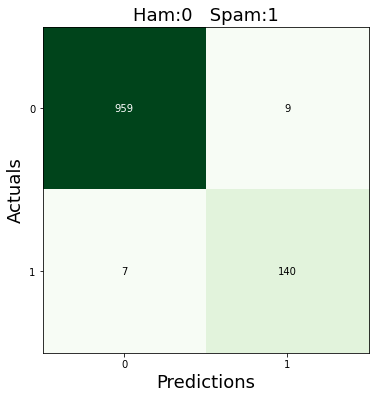

In [84]:
evaluat(nv_pred,y_test)

### Random Forest

Gives good results with CountVectorizer and disaster results with TF-IDF<br>
Also very fast trainig

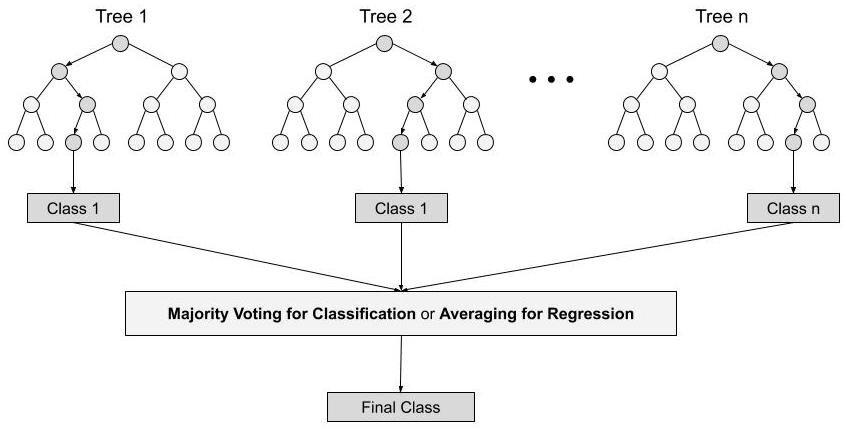

In [115]:
rf=RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(x_tr_dtm,y_train)

RandomForestClassifier(random_state=1)

In [116]:
rf_pred = rf.predict(x_test_dtm)

Recall score:  0.8367346938775511
Accuracy score:  0.9748878923766816
F1 score:  0.8978102189781023
Precision score:  0.968503937007874


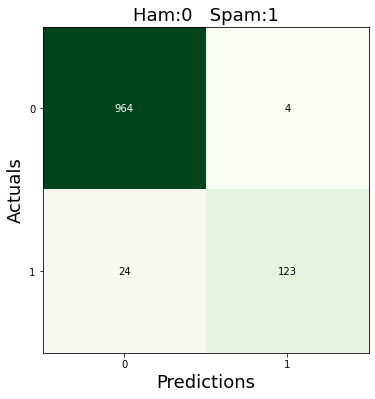

In [117]:
evaluat(rf_pred,y_test)

### SVM

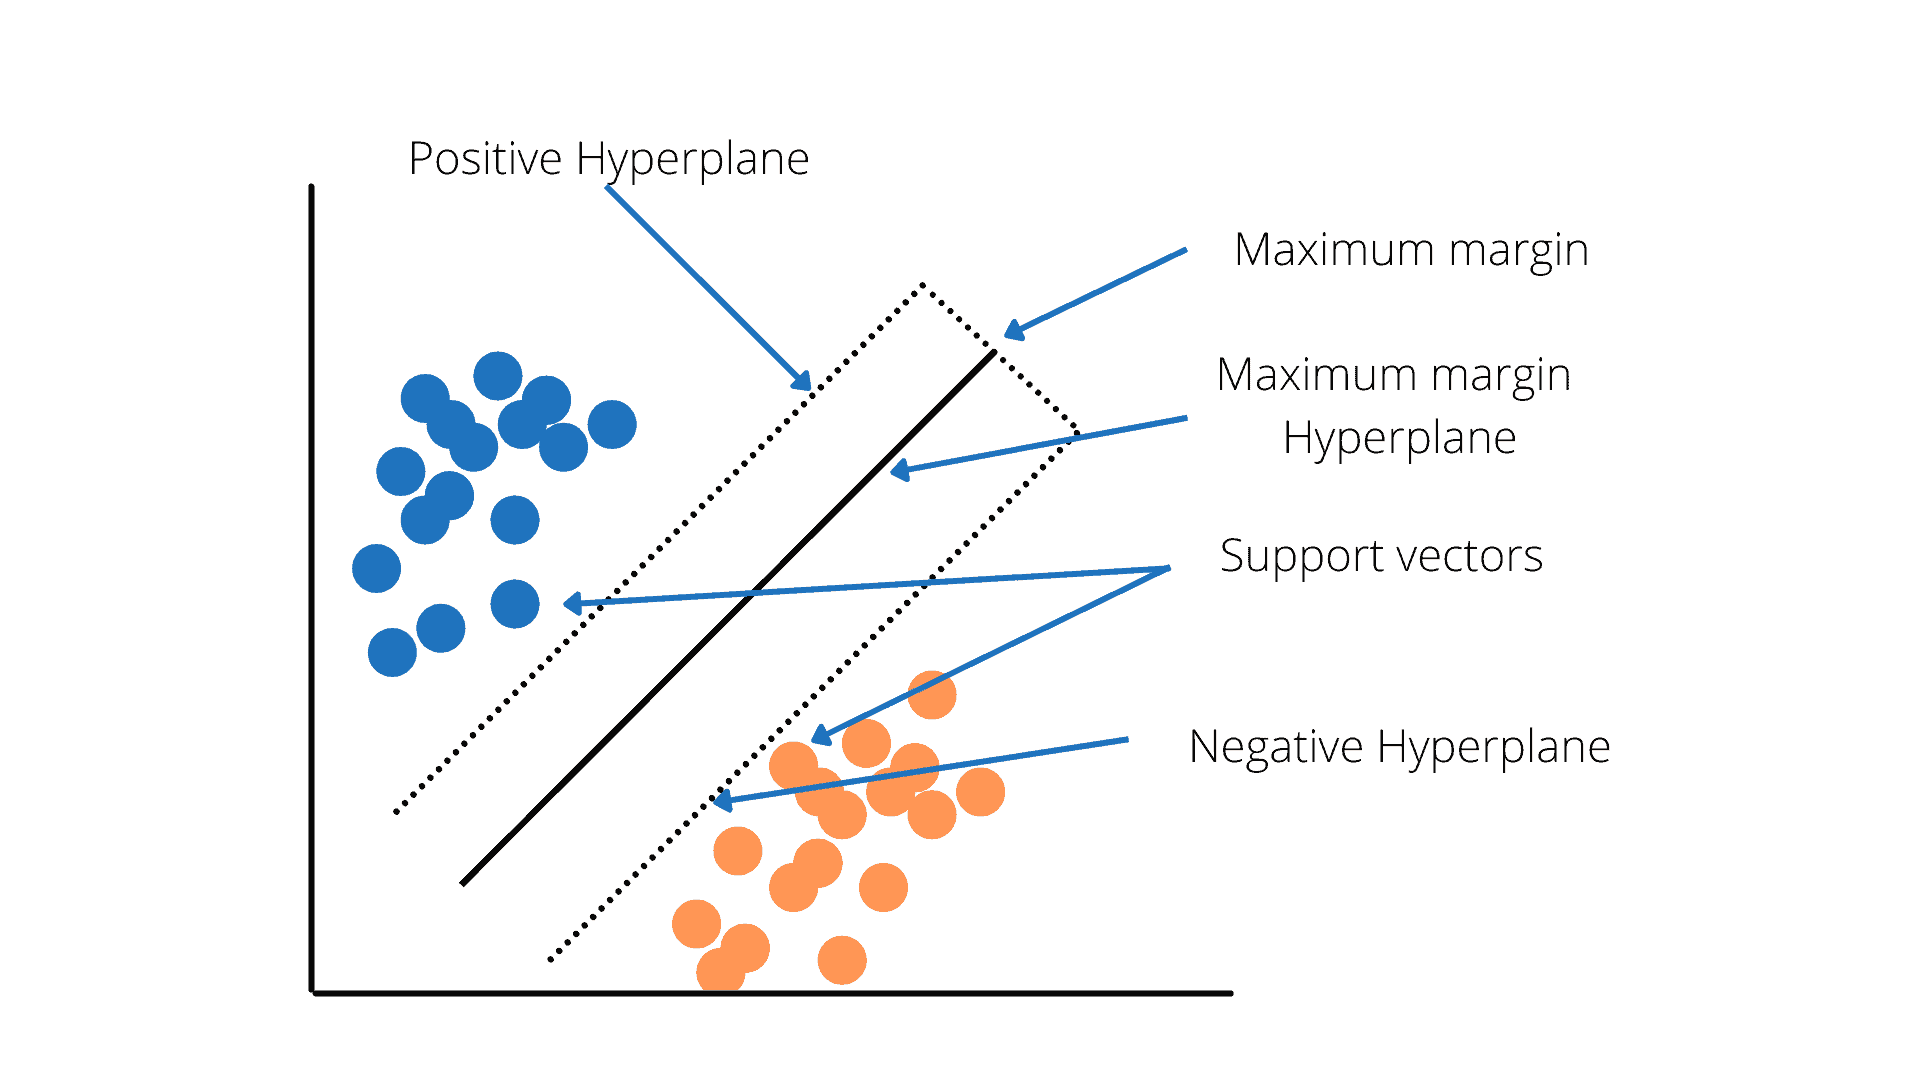

#### Gives the same results as Random Foreset !
Gives good results with CountVectorizer and disaster results with TF-IDF<br>
Also very fast trainig !

In [121]:
#C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None
#Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
#Degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.
svm=SVC(random_state=1)
svm.fit(x_tr_dtm,y_train)

SVC(random_state=1)

In [122]:
svm_pred = rf.predict(x_test_dtm)

Recall score:  0.8367346938775511
Accuracy score:  0.9748878923766816
F1 score:  0.8978102189781023
Precision score:  0.968503937007874


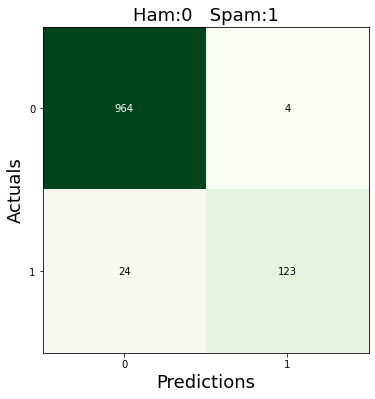

In [123]:
evaluat(svm_pred,y_test)